[1.0, 0.9935064935064936, 0.974025974025974, 0.948051948051948, 0.922077922077922, 0.8701298701298701, 0.8181818181818182, 0.6948051948051948, 0.5194805194805194, 0.24025974025974026, 0.0]


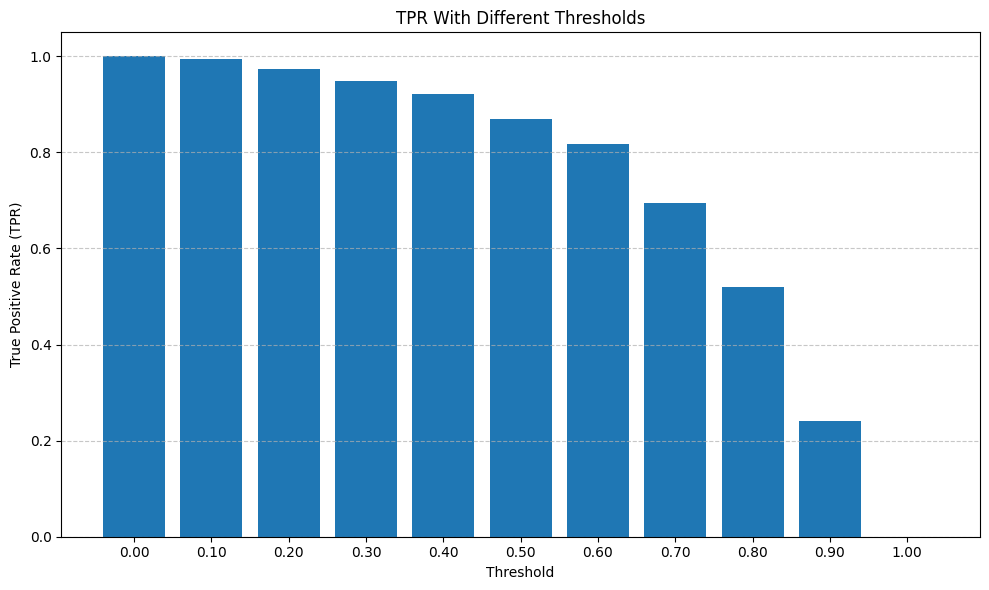

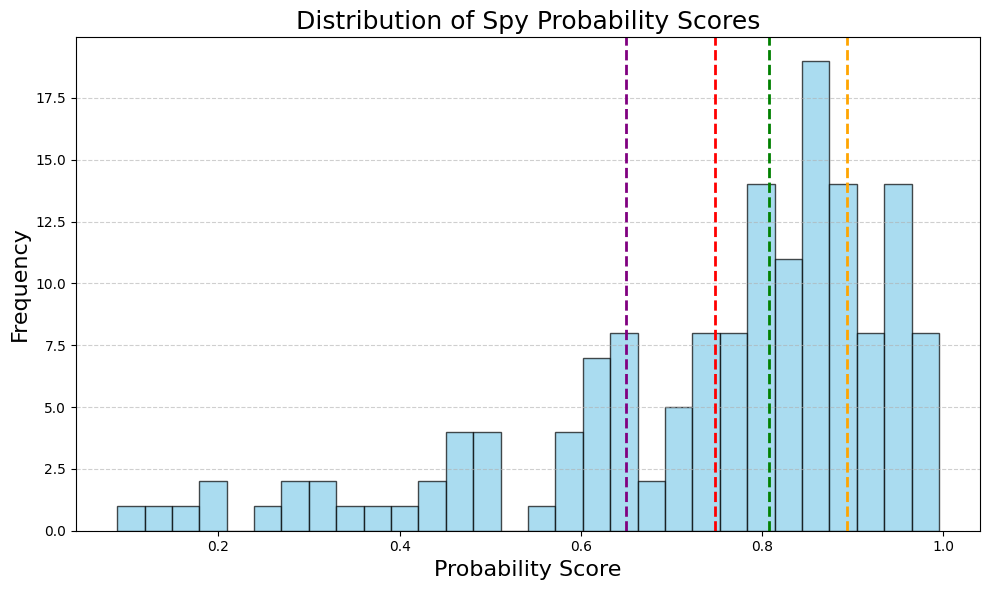


Spy Capture Rate is 0.748, 50th Percentile is 0.808, Top 25th is 0.893, Bottom 25th is 0.649



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

# Load the CSV
df = pd.read_csv("spy_capture_rates.csv")

# Extract base protein ID (e.g., 1ZHY) from filename
df['protein_id'] = df['filename'].apply(lambda x: os.path.basename(x)[:7])

# Function to compute and plot TPR for grouped DataFrame
def plot_tpr(grouped_df, title):
    thresholds = np.arange(0.0, 1.01, 0.1)
    total = len(grouped_df)
    tprs = [(grouped_df["average_score"] > t).sum() / total for t in thresholds]
    print(tprs)

    plt.figure(figsize=(10, 6))
    plt.bar([f"{t:.2f}" for t in thresholds], tprs)
    plt.xlabel("Threshold")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot TPRs
plot_tpr(df, "TPR With Different Thresholds")

# Optional: print summary stats for mean version
mean_score = df["average_score"].mean()
per_50 = df["average_score"].quantile(0.5)
top_25 = df["average_score"].quantile(0.75)
bottom_25 = df["average_score"].quantile(0.25)

plt.figure(figsize=(10, 6))
plt.hist(df["average_score"], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.3f}')
plt.axvline(per_50, color='green', linestyle='--', linewidth=2, label=f'50th Percentile: {per_50:.3f}')
plt.axvline(top_25, color='orange', linestyle='--', linewidth=2, label=f'Top 25%: {top_25:.3f}')
plt.axvline(bottom_25, color='purple', linestyle='--', linewidth=2, label=f'Bottom 25%: {bottom_25:.3f}')

plt.xlabel("Probability Score", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Spy Probability Scores", fontsize=18)
#plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Truncate function
def truncate(f, n):
    return int(f * 10**n) / 10**n

print(f"\nSpy Capture Rate is {truncate(mean_score, 3)}, 50th Percentile is {truncate(per_50, 3)}, "
      f"Top 25th is {truncate(top_25, 3)}, Bottom 25th is {truncate(bottom_25, 3)}\n")


In [2]:
# Step 3: Label based on comparison
def assign_label(score):
    if score > top_25:
        return "StrongPositive"
    elif score < bottom_25:
        return "StrongNegative"
    elif score > per_50:
        return "PseudoPositive"
    else:
        return "PseudoNegative"
    
# Custom function to return mode; if multiple, returns first one
def mode_label(series):
    return series.mode().iloc[0] if not series.mode().empty else None

# Define the threshold-based label assignment
def assign_label_threshold(score, threshold=0.5):
    return 'PseudoPositive' if score >= threshold else 'PseudoNegative'

In [3]:
def show_info(capture_rate_csv, label_csv, spy_mean, spy_50, spy_top25, spy_bottom25):
    df = pd.read_csv(capture_rate_csv)

    # Extract protein ID from filename
    df['protein_id'] = df['filename'].apply(lambda x: os.path.basename(x)[:7])
    print(len(df['protein_id']), "is length of protein id's")

    # Choose either version for stats and labeling (e.g., use mean here)
    df1 = df.copy()

    # Compute descriptive stats
    feature = 'average_score'
    min_score = df1[feature].min()
    max_score = df1[feature].max()
    median_score = df1[feature].median()
    mean_score = df1[feature].mean()

    # Filter by atom count ranges
    filtered_df_40_80 = df1[(df1["number_atoms"] >= 40) & (df1["number_atoms"] <= 80)]
    mean_filtered_40_80 = filtered_df_40_80["average_score"].mean()

    filtered_df_55_65 = df1[(df1["number_atoms"] >= 55) & (df1["number_atoms"] <= 65)]
    mean_filtered_55_65 = filtered_df_55_65["average_score"].mean()

    # Print descriptive stats (truncated)
    print(f"\nSmallest average_score: {min_score:.6f}")
    print(f"Largest average_score: {max_score:.6f}")
    print(f"Median average_score: {median_score:.6f}")
    print(f"Mean average_score: {mean_score:.6f}")
    print(f"Mean average_score (number_atoms between 40 and 80): {mean_filtered_40_80:.6f}")
    print(f"Mean average_score (number_atoms between 55 and 65): {mean_filtered_55_65:.6f}")

    # Truncate for display
    spy_mean = truncate(spy_mean, 3)
    spy_50 = truncate(spy_50, 3)
    spy_top25 = truncate(spy_top25, 3)
    spy_bottom25 = truncate(spy_bottom25, 3)

    print(f"\nSpy Capture Rate is {spy_mean}, 50th Percentile is {spy_50}, Top 25th is {spy_top25}, Bottom 25th is {spy_bottom25}\n")

    # Assign labels to mean-aggregated version
    df1['label'] = df1['average_score'].apply(assign_label)
    df1_counts = df1['label'].value_counts()

    # Load second DataFrame and re-label its categories
    df2 = pd.read_csv(label_csv)

    df2['protein_id'] = df2['filename'].apply(lambda x: os.path.basename(x)[:7])

    df2_counts = df2['label'].value_counts()
    df2_counts.index = df2_counts.index.map({
        "LikelyPositive": "PseudoPositive",
        "LikelyNegative": "PseudoNegative",
        "TruePositive": "StrongPositive",
        "TrueNegative": "StrongNegative"
    })

    # Make a copy of df1
    df3 = df1.copy()

    # Apply the label assignment with threshold 0.5
    df3['label'] = df3['average_score'].apply(lambda x: assign_label_threshold(x, threshold=0.5))

    # Optionally, get counts of each label
    df3_counts = df3['label'].value_counts()

    # Combine counts into a comparison table
    comparison_df = pd.DataFrame({
        "Percentile (Using 50th Per)": df1_counts,
        "Min_Max (Using Spy Cap)": df2_counts,
        "0.5 Threshold" : df3_counts
    }).fillna(0).astype(int)

    print(comparison_df)

In [4]:
# Load the CSV
show_info("test_positive_capture_rates.csv", "test_positive_labels.csv", mean_score, per_50, top_25, bottom_25)

154 is length of protein id's

Smallest average_score: 0.190861
Largest average_score: 0.994129
Median average_score: 0.840148
Mean average_score: 0.768068
Mean average_score (number_atoms between 40 and 80): 0.730767
Mean average_score (number_atoms between 55 and 65): 0.634828

Spy Capture Rate is 0.748, 50th Percentile is 0.808, Top 25th is 0.893, Bottom 25th is 0.649

                Percentile (Using 50th Per)  Min_Max (Using Spy Cap)  0.5 Threshold
label                                                                              
PseudoNegative                           37                       59             19
PseudoPositive                           31                       95            135
StrongNegative                           36                        0              0
StrongPositive                           50                        0              0


In [5]:
show_info("test_unlabeled_capture_rates.csv", "test_unlabeled_labels.csv", mean_score, per_50, top_25, bottom_25)

554 is length of protein id's

Smallest average_score: 0.000178
Largest average_score: 0.967902
Median average_score: 0.102220
Mean average_score: 0.190338
Mean average_score (number_atoms between 40 and 80): 0.256744
Mean average_score (number_atoms between 55 and 65): 0.309900

Spy Capture Rate is 0.748, 50th Percentile is 0.808, Top 25th is 0.893, Bottom 25th is 0.649

                Percentile (Using 50th Per)  Min_Max (Using Spy Cap)  0.5 Threshold
label                                                                              
PseudoNegative                           23                      287            497
PseudoPositive                            6                       14             57
StrongNegative                          522                      253              0
StrongPositive                            3                        0              0


In [6]:
show_info("test_positive_unlabeled_capture_rates.csv", "test_positive_unlabeled_labels.csv", mean_score, per_50, top_25, bottom_25)

369 is length of protein id's

Smallest average_score: 0.008542
Largest average_score: 0.985674
Median average_score: 0.545898
Mean average_score: 0.560117
Mean average_score (number_atoms between 40 and 80): 0.433141
Mean average_score (number_atoms between 55 and 65): 0.365551

Spy Capture Rate is 0.748, 50th Percentile is 0.808, Top 25th is 0.893, Bottom 25th is 0.649

                Percentile (Using 50th Per)  Min_Max (Using Spy Cap)  0.5 Threshold
label                                                                              
PseudoNegative                           55                      232            166
PseudoPositive                           53                      124            203
StrongNegative                          214                       13              0
StrongPositive                           47                        0              0


In [7]:
show_info("ivan_capture_rates.csv", "ivan_labels.csv", mean_score, per_50, top_25, bottom_25)

df = pd.read_csv("ivan_capture_rates.csv")

# Extract protein ID from filename
df['protein_id'] = df['filename'].apply(lambda x: os.path.basename(x)[:7])
print(len(df['protein_id']), "is length of protein id's")

# Assign labels to mean-aggregated version
num_samples = (df['average_score'] > 0.102220).sum()
print("\nNumber of samples greater than unlabeled median are", num_samples)

57 is length of protein id's

Smallest average_score: 0.011182
Largest average_score: 0.994032
Median average_score: 0.813798
Mean average_score: 0.720495
Mean average_score (number_atoms between 40 and 80): 0.584447
Mean average_score (number_atoms between 55 and 65): 0.510105

Spy Capture Rate is 0.748, 50th Percentile is 0.808, Top 25th is 0.893, Bottom 25th is 0.649

                Percentile (Using 50th Per)  Min_Max (Using Spy Cap)  0.5 Threshold
label                                                                              
PseudoNegative                            8                       24             12
PseudoPositive                            8                       32             45
StrongNegative                           19                        1              0
StrongPositive                           22                        0              0
57 is length of protein id's

Number of samples greater than unlabeled median are 56
